In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import pandas as pd
import prettyplotlib as ppl
import numpy as np
import scipy.stats as stats
from scipy.interpolate import interp1d
import scipy
import statsmodels.api as sm
from scipy import signal
from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
from numpy.fft import fft, ifft, ifftshift
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
df = pd.read_csv('final_data_files/uncrowded_everything_m4_clipped_fehtest.csv')
dfab = df[df.type == 0]
dfc = df[df.type == 1]

0.0428631543403
[-0.0178]


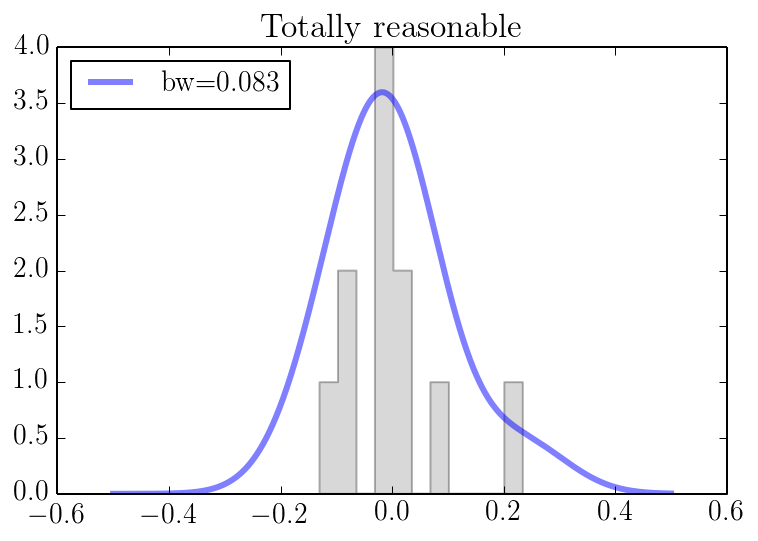

In [5]:
condition = np.isfinite(dfab.resid_m4_3.values)

resid3 = dfab.resid_m4_3.values[condition]
errscale = np.median(dfab.merr_3.values[condition])
print errscale

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 0.2, 100)},
                    cv=len(resid3) - 1) # 20-fold cross-validation
grid.fit(resid3[:,None])

delta = 1e-4
big_grid = np.arange(-0.5,0.5,delta)
kde = grid.best_estimator_
actual_pdf = np.exp(kde.score_samples(big_grid[:, None])) #* delta

print big_grid[actual_pdf==actual_pdf.max()]
fig, ax = plt.subplots()
ax.plot(big_grid, actual_pdf, linewidth=3, alpha=0.5, label='bw=%.3f' % kde.bandwidth)
ax.hist(resid3, len(resid3), fc='gray', histtype='stepfilled', alpha=0.3)
ax.legend(loc='upper left', prop={'size':14})
ax.set_title('Totally reasonable')

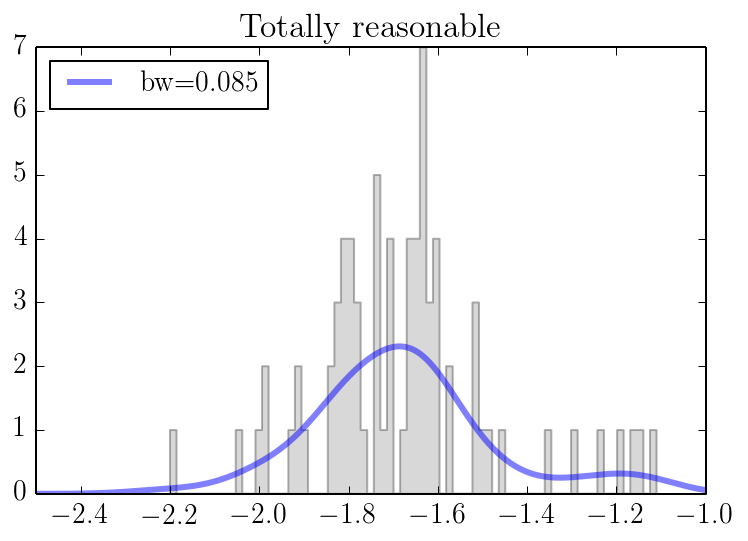

In [16]:
condition = np.isfinite(df.spectfeh.values)

resid3 = df.spectfeh.values[condition]
#errscale = np.median(dfab.merr_3.values[condition])
#print errscale

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 0.2, 100)},
                    cv=len(resid3) - 1) # 20-fold cross-validation
grid.fit(resid3[:,None])

delta = 1e-4
big_grid = np.arange(-3,1,delta)
kde = grid.best_estimator_
actual_pdf = np.exp(kde.score_samples(big_grid[:, None])) #* delta

fig, ax = plt.subplots()
ax.plot(big_grid, actual_pdf, linewidth=3, alpha=0.5, label='bw=%.3f' % kde.bandwidth)
ax.hist(resid3, len(resid3), fc='gray', histtype='stepfilled', alpha=0.3)
ax.set_xlim(-2.5,-1)
ax.legend(loc='upper left', prop={'size':14})
ax.set_title('Totally reasonable')

In [8]:
full_width_of_PL = np.sqrt(12.)*0.035
center_of_PL = -full_width_of_PL / 2
intrinsic = stats.uniform(loc=center_of_PL,scale=full_width_of_PL)
photometric = stats.norm(loc=0,scale=errscale)

## I'm not including a metallicity term at this point, becuase we haven't worked it out yet.

# NB Kernel support array **MUST** be symmetric about centre of the kernel (error PDF) for this to work right. 
# Support also needs to extend about any significant areas of the component PDFs.
# Here, we just define one massive support for both input PDF, and error PDF (kernel)
# But we can do much better (see later)

#NB step-size determines precision of approximation
#delta = 1e-4
#big_grid = np.arange(-.5,.5,delta)

# Cannot analytically convolve continuous PDFs, in general.
# So we now make a probability mass function on a fine grid 
# - a discrete approximation to the PDF, amenable to FFT...
pmf1 = intrinsic.pdf(big_grid)*delta
pmf2 = photometric.pdf(big_grid)*delta
conv_pmf = scipy.signal.fftconvolve(pmf1,pmf2,'same') # Convolved probability mass function
print "Grid length, sum(gauss_pmf), sum(uni_pmf),sum(conv_pmf):"
print len(big_grid), sum(photometric.pdf(big_grid)*delta), sum(intrinsic.pdf(big_grid)*delta), sum(conv_pmf)
conv_pmf = conv_pmf/sum(conv_pmf)

Grid length, sum(gauss_pmf), sum(uni_pmf),sum(conv_pmf):
20000 1.0 1.0004655379 1.0004655379


Just by adding the photometric uncertainties to this PL, we're seeing it look more like a gaussian.

[  5.59954886e-29   5.67084351e-29   5.74303755e-29 ...,   1.38273235e-23
   1.36742664e-23   1.35228840e-23] [ 0.  0.  0. ...,  0.  0.  0.] [  5.98930243e-122   6.32431293e-122   6.67802584e-122 ...,
   7.05148320e-122   6.67802584e-122   6.32431293e-122]
20000 20000 20000


(<matplotlib.legend.Legend at 0x10ef354d0>,
 <matplotlib.text.Text at 0x10ef40b10>)

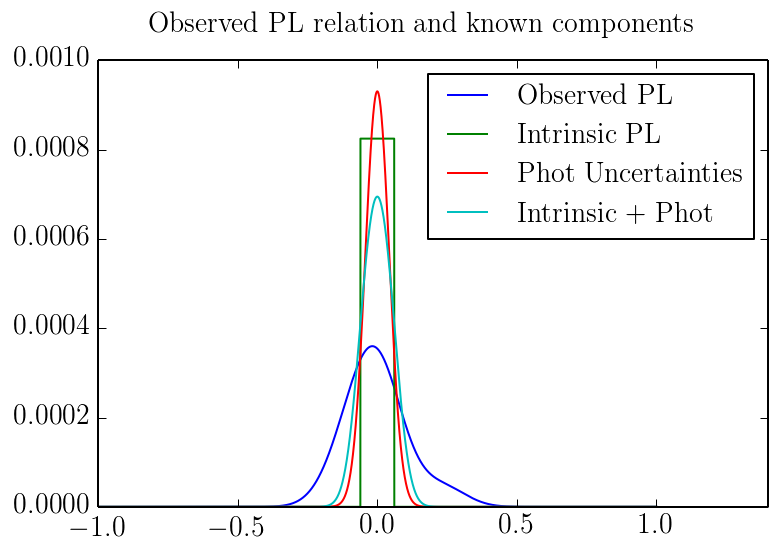

In [9]:
full_width_of_PL = np.sqrt(12.)*0.035
center_of_PL = -full_width_of_PL / 2
intrinsic = stats.uniform(loc=center_of_PL,scale=full_width_of_PL)
photometric = stats.norm(loc=0,scale=errscale)

observed_PL_1sigma = 0.0843634290098
observed_PL_relation = stats.norm(loc=0,scale=observed_PL_1sigma)

#NB step-size determines precision of approximation
#delta = 1e-4
#big_grid = np.arange(-.5,.5,delta)


## Setting up the PDFs and PMFs for the components
pmf_o = actual_pdf * delta # observed_PL_relation.pdf(big_grid)*delta
pmf_i = intrinsic.pdf(big_grid)*delta
pmf_p = photometric.pdf(big_grid)*delta

print pmf_o, pmf_i, pmf_p
print len(pmf_o), len(pmf_i), len(pmf_p)

conv_pmf = scipy.signal.fftconvolve(pmf_i,pmf_p,'same')
conv_pmf = conv_pmf/sum(conv_pmf)

plt.plot(big_grid,pmf_o, label='Observed PL')
plt.plot(big_grid,pmf_i, label='Intrinsic PL')
plt.plot(big_grid,pmf_p, label='Phot Uncertainties')
plt.plot(big_grid, conv_pmf, label='Intrinsic + Phot')
plt.xlim(min(big_grid),max(big_grid)+0.4)
plt.ylim(0,0.001)
plt.legend(loc='best', prop={'size':14}), plt.suptitle('Observed PL relation and known components')



I've corrected the convolution code above, and there **is** a difference between the convolution of the intrinsic + photometric distributions and the observed PL --> There is a missing term that needs to be accounted for.

I've been trying to get the deconvolution stuff to work all day, and I can't do it. So we're going old school. Brute force all the way.

(<matplotlib.legend.Legend at 0x10ddf0550>,
 <matplotlib.text.Text at 0x10fe165d0>)

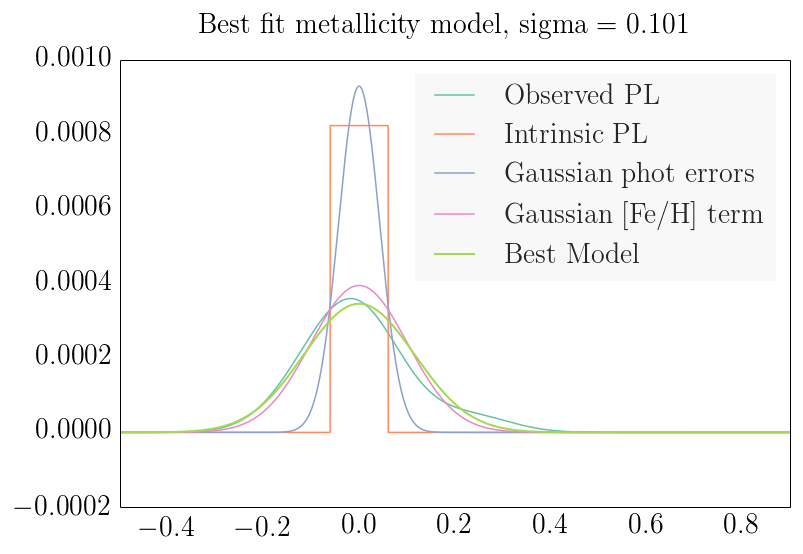

In [11]:
## Deconvolution is hard.

## Can I brute force this??

#First convolve the intrinsic PL and the photometric errors. This will be the same every time
conv_pmf = scipy.signal.fftconvolve(pmf_i,pmf_p,'same')

difference_min = 10000000

# Then iterate over a range of values for the uncertainty introduced by metallicity
for metals in np.linspace(0, 0.25, 100):
    metallicity = stats.norm(loc=0,scale=metals)
    pmf_m = metallicity.pdf(big_grid)*delta
    metallicity_convolved = scipy.signal.fftconvolve(conv_pmf, pmf_m, 'same')
    metallicity_convolved = metallicity_convolved/sum(metallicity_convolved)

    ## Check how different this is from the observed PL
    ## I tried using the ratio of the convoltion and the observed PL, but that was shit.
    ## What about the absolute difference?
    difference = sum(abs(metallicity_convolved - pmf_o))
    if difference < difference_min:
        difference_min = difference
        best_metallicity = metals
        best_metallicity_pmf = pmf_m
        best_convolved = metallicity_convolved

ppl.plot(big_grid,pmf_o, label='Observed PL')
ppl.plot(big_grid,pmf_i, label='Intrinsic PL')
ppl.plot(big_grid,pmf_p, label='Gaussian phot errors')
ppl.plot(big_grid,best_metallicity_pmf, label="Gaussian [Fe/H] term")
plt.plot(big_grid, best_convolved, label="Best Model")
plt.xlim(-0.5, 0.9)

title_text = 'Best fit metallicity model, sigma = {:.3f}'.format(best_metallicity)
ppl.legend(loc='best', prop={'size':14}), plt.suptitle(title_text)


    

Estimation of the upper limit of the metallicity term, by convolution of probability density functions:
-------------------------------------------------------------------------------------------------
* We observe the $\omega$ Cen PL relation to have a dispersion of $\sigma_{obs} = 0.084$
* Assume that the intrinsic PL relation is a uniform distribution with $\sigma_{int} = 0.35$ (M4, [3.6], RRab)
* Assume the photometric uncertainties are distributed gaussianly (totally a word) with $\sigma_{phot} = 0.049$
* Assuming that all the rest of the dispersion in the *observed* PL relation is due to the metallicity spread of $\omega$ Cen, and that the metallicities are distributed gausiannly around the mean metallicity:

$$P(obs) = P(int) * P(phot) * P(metal)$$

* Tested all values of $\sigma_{metal}$ between 0 and 0.1, with a step size of 0.01. Best fit value for [3.6] RRab's is $\sigma_{metal} = 0.06$ mag. 

** TO DO ** Meredith - Do you want to do these??
* Is the shape of the metallicity distribution reasonable? 
 - Do we need to be using a skewed gaussian or something?
 - Can we match the observed metallicity distribution somehow?
* Shape of the osbserved PL residuals for [4.5] were not gaussian
 - What function should we use for that??
 - Same as for metallicity - should it be a skewed distribution?
* Estimation of uncertainties 
 - Can also do this by brute force
 - How much do you need to change $\sigma_{metal} to change the difference by 1 sigma??
* Calculate this result for the other bands and other RRL types
* Compare between bands and types